# **Projeto S**

## *Pacotes e Bibliotecas*

In [1]:
# Pacotes e Bibliotecas
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from google.oauth2 import service_account
from google.cloud import bigquery

import warnings
warnings.filterwarnings('ignore')

## *Código para os cursos oferecidos pelo SENAC/RN*

### Extração dos cursos oferecidos diretamente do site

In [91]:
# URL do site com a lista de cursos
url = 'https://www.rn.senac.br/todos-os-cursos'

# Requisição para acessar página
resposta_cursos = requests.get(url)
resposta_cursos.raise_for_status()  

# Verifica o HTML usando BeautifulSoup
palavras = BeautifulSoup(resposta_cursos.content, 'html.parser')
cursos = [a.text for a in palavras.select('a')]

# Transforma a lista de nomes em um DataFrame
df_cursos = pd.DataFrame(cursos, columns=['Curso']).reindex()

### Ajustando dataframe para análise

In [92]:
# Excluindo dados que não sejam os cursos
df_cursos = df_cursos.loc[df_cursos['Curso'].str.contains(' - ', na=False)].reset_index(drop=True)

In [93]:
# Separando a classe do curso e o curso propriamente dito
df_cursos[['Classe', 'Curso_senac']] = df_cursos['Curso'].str.split(' - ', n=1, expand=True)
df_cursos = df_cursos.drop(columns='Curso')

# Removendo '\r\n' e espaços em branco adicionais
df_cursos['Classe'] = df_cursos['Classe'].str.replace(r'\s*\r\n\s*', '', regex=True)
df_cursos['Curso_senac'] = df_cursos['Curso_senac'].str.replace(r'\s*\r\n\s+', '', regex=True)

## *Código para acessar banco de dados do Novo CAGED e descrições dos microdados*

### Conectando e consultando o banco de dados BigQuery e planilhas com as descrições dos microdados

In [5]:
# Consultando a chave de acesso ao banco de dados BigQuery
key_path = "D:/Projeto_S/baseprojetos-trab.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

# Configurar o cliente BigQuery
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

Consulta SQL para extração de dataframe

In [15]:
# consulta SQL ao banco de dados de movimentações do CAGED executando os filtros necessários para o projeto
query_movimentacoes = """
    SELECT 
        ano, 
        mes, 
        sigla_uf, 
        cnae_2_secao, 
        cnae_2_subclasse, 
        cbo_2002,
        saldo_movimentacao,
        tipo_movimentacao
    FROM 
        `baseprojetos.caged_rn.caged_rn`
    WHERE 
        ano = 2023
        AND sigla_uf = 'RN'
        --AND tipo_movimentacao IN ('10', '20', '25', '97')
"""

# Executar a consulta e transformar os resultados em um DataFrame
df_caged_sql = client.query(query_movimentacoes).to_dataframe()

# Exibir o DataFrame
df_caged_sql

,ano,mes,sigla_uf,cnae_2_secao,cnae_2_subclasse,cbo_2002,saldo_movimentacao,tipo_movimentacao
0,2023,8,RN,B,810002,784205,1,97
1,2023,8,RN,B,810002,784205,1,97
2,2023,8,RN,B,810099,919105,-1,31
3,2023,8,RN,C,1412601,763320,-1,31
4,2023,8,RN,C,1412601,763215,-1,31
...,...,...,...,...,...,...,...,...
395524,2023,7,RN,T,9700500,391115,1,97
395525,2023,7,RN,G,4635402,521140,-1,98
395526,2023,7,RN,G,4772500,411010,-1,98
395527,2023,7,RN,O,8411600,351105,-1,98


In [16]:
# Dataframes a partir do excel
cnae_secao = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Estabelecimento.xlsx', sheet_name='seção')
cnae_subclasse = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Estabelecimento.xlsx', sheet_name='subclasse')
cbo_2002 = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Movimentação.xlsx', sheet_name='cbo2002ocupação')
tipo_movimentacao = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Movimentação.xlsx', sheet_name='tipomovimentação')

### Ajustes dos dataframes para análises

Ajustes dos dataframes para análises

In [17]:
# Ajustando tipo de coluna para cnae_secao
cnae_secao = cnae_secao.rename(
    columns={
        'Código' : 'Cod_secao',
        'Descrição' : 'Desc_secao'
        }
)

# Ajustando tipo de coluna para cnae_subclasse
cnae_subclasse = cnae_subclasse.rename(
    columns={
        'Código' : 'Cod_Subclasse',
        'Descrição' : 'Desc_subclasse'
        }
)
cnae_subclasse['Cod_Subclasse'] = cnae_subclasse['Cod_Subclasse'].astype(str)

# Ajustando tipo de coluna para cbo_2002
cbo_2002 = cbo_2002.rename(
    columns={
        'Código' : 'Cod_cbo_2002',
        'Descrição' : 'Desc_cbo_2002'
        }
)
cbo_2002['Cod_cbo_2002'] = cbo_2002['Cod_cbo_2002'].astype(str)

# Ajustando tipo de coluna para tipo_movimentacao
tipo_movimentacao = tipo_movimentacao.rename(
    columns={
        'Código' : 'Cod_tipo_movimentacao',
        'Descrição' : 'Desc_tipo_movimentacao'
        }
)
tipo_movimentacao['Cod_tipo_movimentacao'] = tipo_movimentacao['Cod_tipo_movimentacao'].astype(str)
tipo_movimentacao = tipo_movimentacao.append(
    {
        'Cod_tipo_movimentacao' : '97',
        'Desc_tipo_movimentacao' : 'Admissão'
    },
    ignore_index=True
)

In [18]:
# Identificando os códigos da tabela df_caged_sql e realizando merge para visualização das descrições de cada coluna
df_analise = pd.merge(df_caged_sql, cnae_secao, left_on='cnae_2_secao', right_on= 'Cod_secao', how='inner')
df_analise = pd.merge(df_analise, cnae_subclasse, left_on='cnae_2_subclasse', right_on='Cod_Subclasse', how='left')
df_analise = pd.merge(df_analise, cbo_2002, left_on='cbo_2002', right_on='Cod_cbo_2002', how='left')
df_analise = pd.merge(df_analise, tipo_movimentacao, left_on='tipo_movimentacao', right_on='Cod_tipo_movimentacao', how='left')

# Excluindo colunas que não serão utilizadas
colunas_excluir = ['sigla_uf','cnae_2_secao', 'cnae_2_subclasse', 'cbo_2002', 'tipo_movimentacao', 'Cod_secao', 'Cod_Subclasse', 'Cod_cbo_2002']
df_analise = df_analise.drop(columns=colunas_excluir)

In [19]:
# Criando coluna de data
df_analise['dia'] = 1
df_analise.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}, inplace=True)
df_analise['mes_ano'] = pd.to_datetime(df_analise[['year', 'month', 'day']])
df_analise['mes_ano'] = df_analise['mes_ano'].dt.strftime('%m/%Y')
df_analise = df_analise.drop(columns=['year', 'month', 'day'])

## *Análises dos dataframes extraídos*

### Visualização do quantitativo de cursos por classe de curso

In [20]:
# Definindo dataframe para análise
df_cursos_viz = df_cursos['Classe'].value_counts().reset_index()
df_cursos_viz.columns = ['Classe', 'Quantidade']

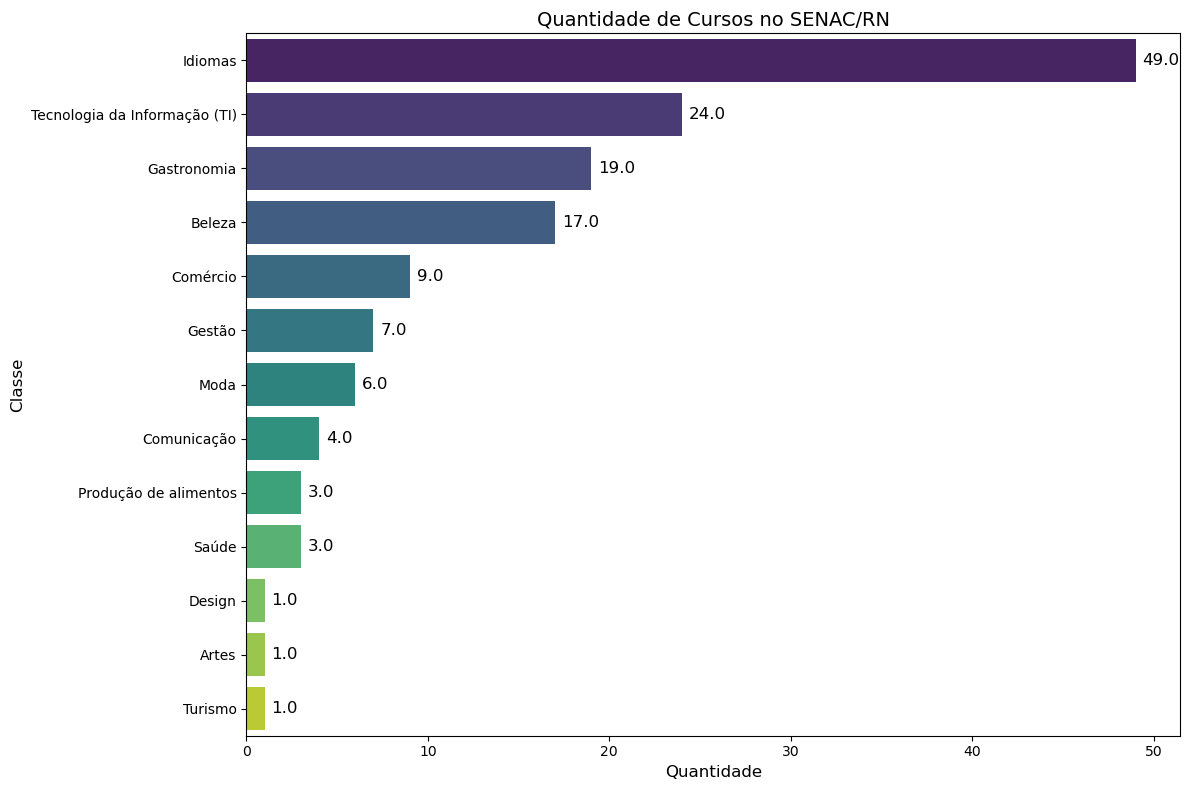

In [34]:
# Criando o gráfico de barras com Seaborn
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x='Quantidade', y='Classe', data=df_cursos_viz, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=12, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=10)

# Adicionando título e rótulos dos eixos
ax.set_title('Quantidade de Cursos no SENAC/RN', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Análise dos dados CAGED - Admissões

**Quantidade de admissões ao longo de 2023**

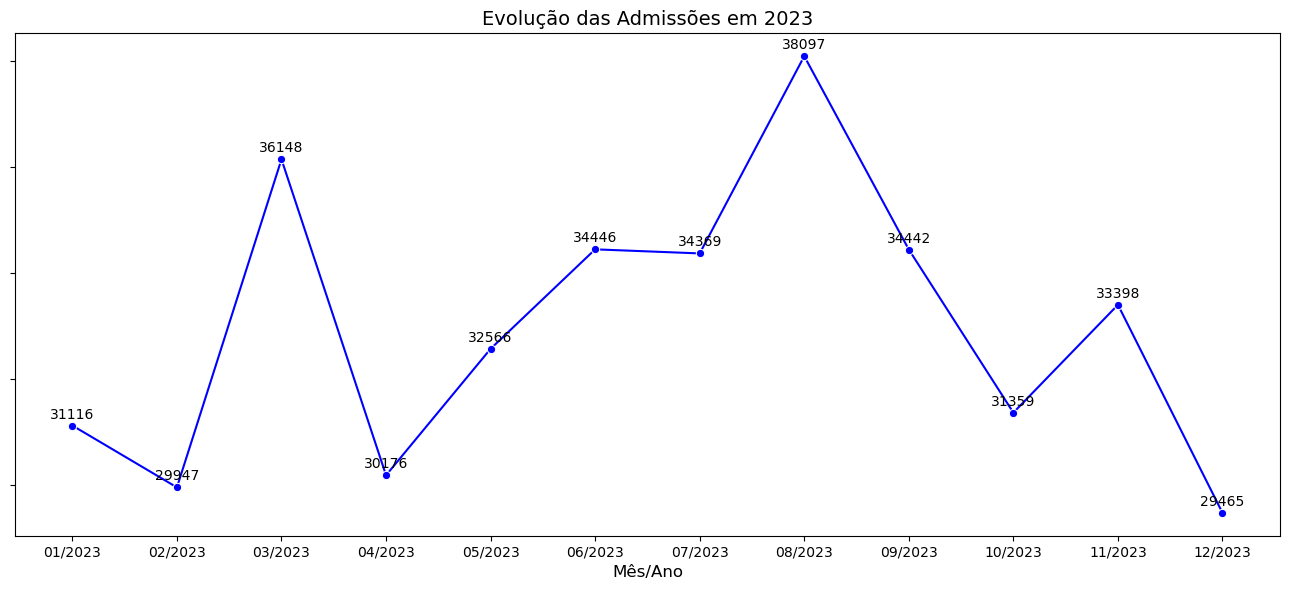

In [36]:
# Dataframe com totais mensais
df_qtd_ano = df_analise.groupby('mes_ano').size().reset_index(name='Quantidade')

# Gráfico de linha
fig, ax = plt.subplots(figsize=(13, 6))

sns.lineplot(x='mes_ano', y='Quantidade', data=df_qtd_ano, marker='o', ax=ax, color='b')

# Adicionando os valores acima de cada ponto
for i, txt in enumerate(df_qtd_ano['Quantidade']):
    ax.annotate(txt, (df_qtd_ano['mes_ano'][i], df_qtd_ano['Quantidade'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

# Ajuste de rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=-0, fontsize=10)

# Título e rótulos dos eixos
ax.set_title('Evolução das Admissões em 2023', fontsize=14)
ax.set_xlabel('Mês/Ano', fontsize=12)
ax.set_ylabel('')

# Ocultando os rótulos do eixo y
ax.set_yticklabels([])

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Estes dados apresentam todas as admissões realizadas no Rio Grande do Norte em 2023. Houve crescimento entre a partir do mês de abril com o pico em agosto. Após este período houve queda nas admissões.

**Quantidade anual de admissões por Atividade Econômica**

In [67]:
# Dataframe com os totais por Seção
df_secao_admissoes = df_analise.groupby('Desc_secao')['saldo_movimentacao'].count().reset_index(name='Quantidade')
df_secao_admissoes = df_secao_admissoes.sort_values(by='Quantidade', ascending=False).reset_index(drop=True)
df_secao_admissoes

,Desc_secao,Quantidade
0,"Comércio, Reparação de Veículos Automotores e ...",100397
1,Construção,63376
2,Atividades Administrativas e Serviços Compleme...,60143
3,Indústrias de Transformação,41150
4,Alojamento e Alimentação,27479
5,"Agricultura, Pecuária, Produção Florestal, Pes...",22359
6,Educação,14707
7,Saúde Humana e Serviços Sociais,13559
8,"Atividades Profissionais, Científicas e Técnicas",13367
9,"Transporte, Armazenagem e Correio",9113


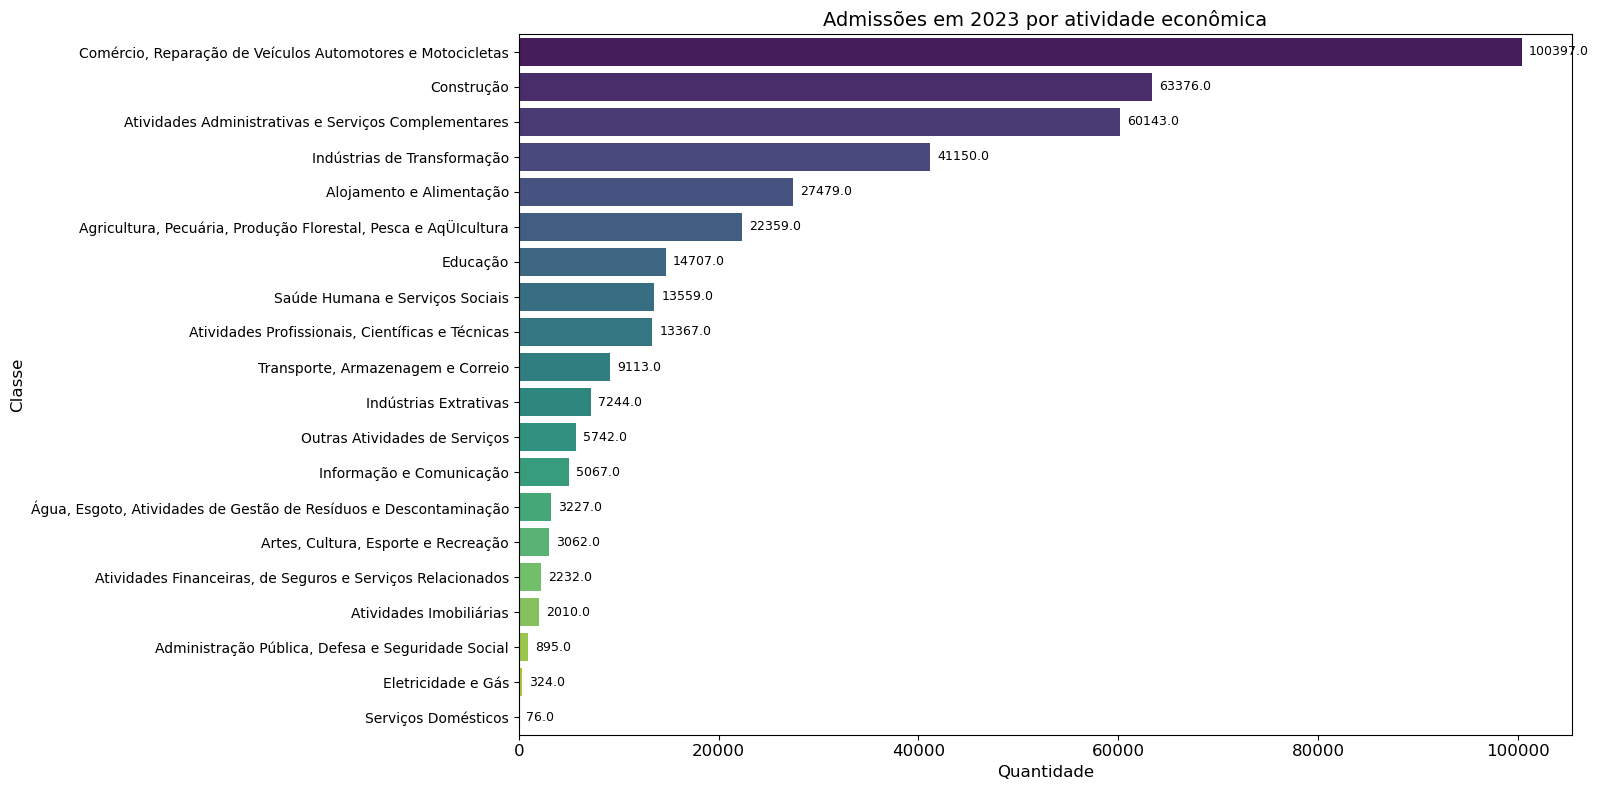

In [69]:
# Gráfico com os totais por atividade econômica
fig2, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='Quantidade', y='Desc_secao', data=df_secao_admissoes, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Admissões em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Quantidade anual de admissões por CNAE 2.0**

In [76]:
# Dataframe com os totais por Subclasse
df_subclasse_admissoes = df_analise.groupby('Desc_subclasse')['saldo_movimentacao'].count().reset_index(name='Quantidade').nlargest(20, 'Quantidade')
df_subclasse_admissoes = df_subclasse_admissoes.sort_values(by='Quantidade', ascending=False).reset_index(drop=True)
df_subclasse_admissoes

,Desc_subclasse,Quantidade
0,Construção de Edifícios,28371
1,Atividades de Teleatendimento,13756
2,"Comércio Varejista de Mercadorias em Geral, co...",13250
3,"Serviços Combinados para Apoio a Edifícios, Ex...",12562
4,Restaurantes e Similares,12113
5,Cultivo de Melão,9771
6,Comércio Varejista de Artigos do Vestuário e A...,8599
7,Hotéis,6181
8,Construção de Estações e Redes de Distribuição...,5684
9,"Comércio Varejista de Mercadorias em Geral, co...",5620


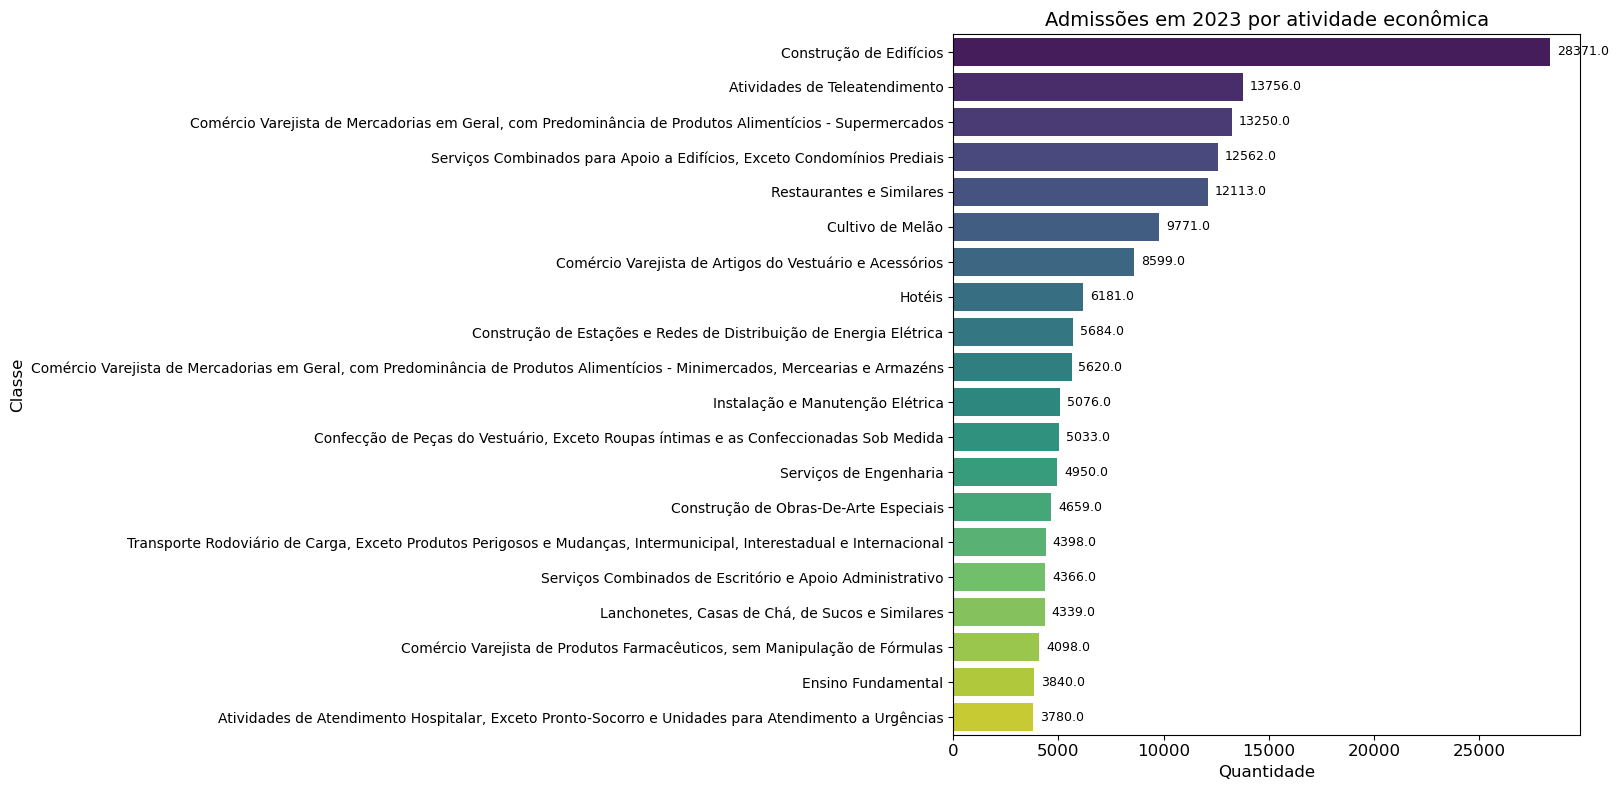

In [77]:
# Gráfico com os totais por subclasse
fig5, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='Quantidade', y='Desc_subclasse', data=df_subclasse_admissoes, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Admissões em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Quantidade anual de admissões por CNAE 2.0**

In [82]:
# Dataframe com os totais por CBO
df_cbo_admissoes = df_analise.groupby('Desc_cbo_2002')['saldo_movimentacao'].count().reset_index(name='Quantidade').nlargest(30, 'Quantidade')
df_cbo_admissoes = df_cbo_admissoes.sort_values(by='Quantidade', ascending=False).reset_index(drop=True)
df_cbo_admissoes

,Desc_cbo_2002,Quantidade
0,Servente de Obras,26513
1,Vendedor de Comercio Varejista,24636
2,Faxineiro (Desativado em 2010),16038
3,Operador de Telemarketing Ativo e Receptivo,13305
4,Assistente Administrativo,12888
5,Pedreiro,11351
6,Operador de Caixa,10684
7,"Auxiliar de Escritorio, em Geral",9945
8,Trabalhador no Cultivo de Especies Frutiferas ...,9330
9,Motorista de Caminhao (Rotas Regionais e Inter...,8004


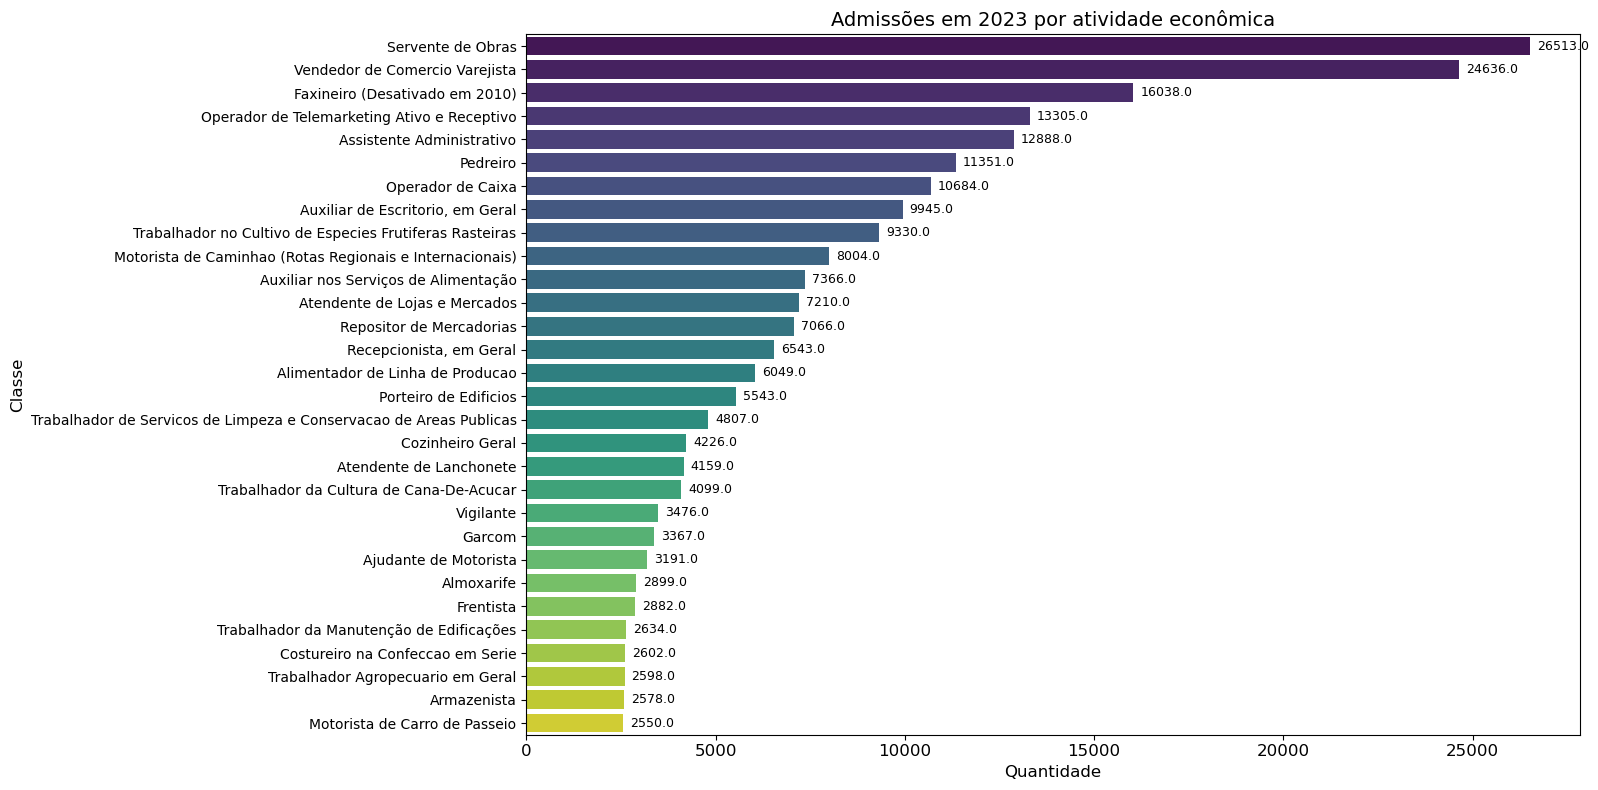

In [83]:
# Gráfico com os totais por CBO
fig5, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='Quantidade', y='Desc_cbo_2002', data=df_cbo_admissoes, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Admissões em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Análise dos dados CAGED - Saldo de Admissões

**Saldo de admissões ao longo de 2023**
*(total de admissões - total de demissões)*

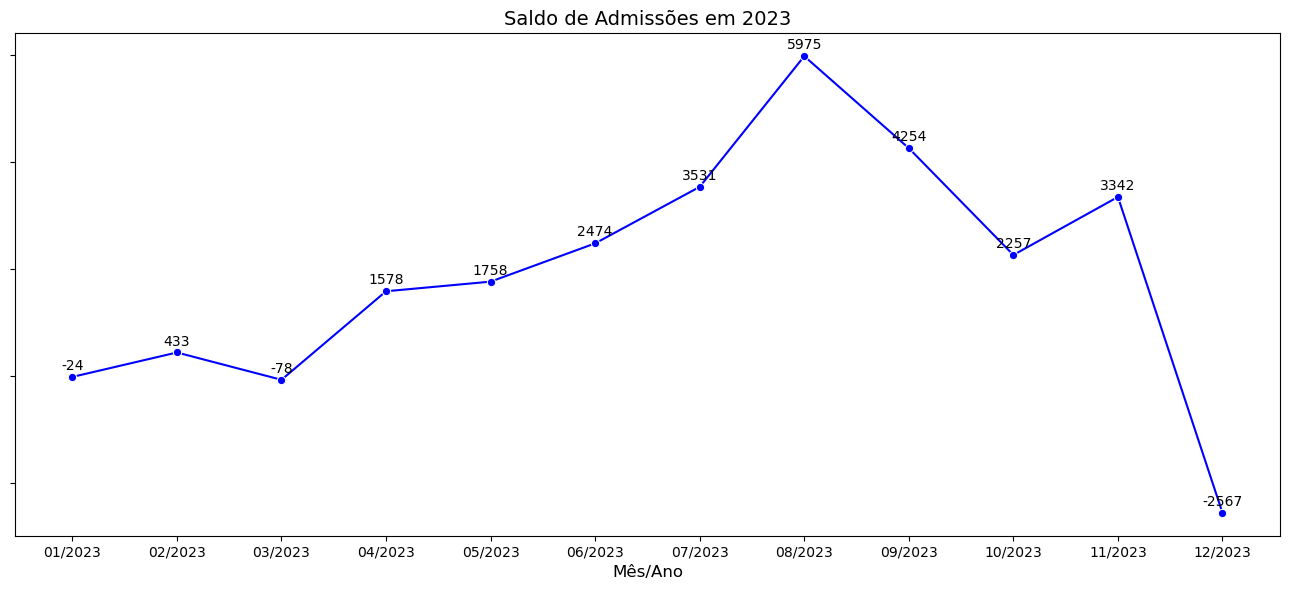

In [38]:
df_saldo_movi_graf = df_analise.groupby('mes_ano')['saldo_movimentacao'].sum().reset_index()

# Criando o gráfico de linha com Seaborn
fig3, ax = plt.subplots(figsize=(13, 6))

sns.lineplot(x='mes_ano', y='saldo_movimentacao', data=df_saldo_movi_graf, marker='o', ax=ax, color='b')

# Adicionando os valores acima de cada ponto
for i, txt in enumerate(df_saldo_movi_graf['saldo_movimentacao']):
    ax.annotate(txt, (df_saldo_movi_graf['mes_ano'][i], df_saldo_movi_graf['saldo_movimentacao'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=-0, fontsize=10)

# Adicionando título e rótulos dos eixos
ax.set_title('Saldo de Admissões em 2023', fontsize=14)
ax.set_xlabel('Mês/Ano', fontsize=12)
ax.set_ylabel('')

# Ocultando os rótulos do eixo y
ax.set_yticklabels([])

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Saldo de admissões anual por Atividade Econômica**

In [35]:
df_secao = df_analise.groupby('Desc_secao')['saldo_movimentacao'].sum().reset_index()
total_secao = df_secao['saldo_movimentacao'].sum()
df_secao['%'] = (df_secao['saldo_movimentacao'] / total_secao) * 100
df_secao['%'] = df_secao['%'].round(2)
df_secao = df_secao.sort_values(by='saldo_movimentacao', ascending=False).reset_index(drop=True)

df_secao

,Desc_secao,saldo_movimentacao,%
0,Atividades Administrativas e Serviços Compleme...,8017,34.96
1,"Comércio, Reparação de Veículos Automotores e ...",4377,19.09
2,Construção,3762,16.4
3,"Agricultura, Pecuária, Produção Florestal, Pes...",1345,5.86
4,Alojamento e Alimentação,867,3.78
5,Indústrias de Transformação,842,3.67
6,Educação,711,3.1
7,"Água, Esgoto, Atividades de Gestão de Resíduos...",477,2.08
8,Indústrias Extrativas,458,2.0
9,"Atividades Profissionais, Científicas e Técnicas",433,1.89


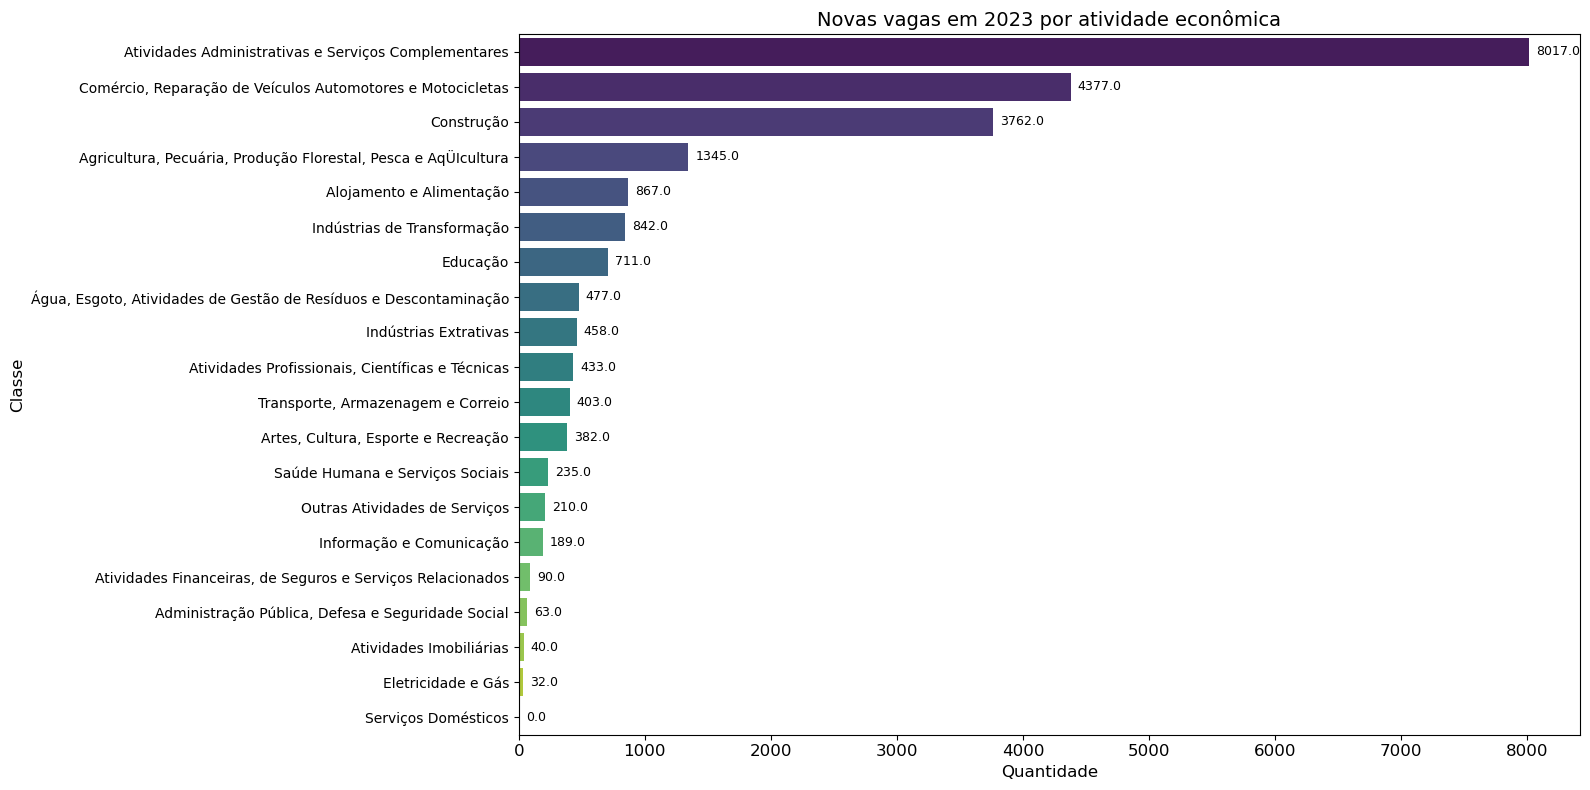

In [56]:
# Criando o gráfico de barras com Seaborn
fig4, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='saldo_movimentacao', y='Desc_secao', data=df_secao, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Novas vagas em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Saldo de admissões anual por CNAE 2.0**

In [99]:
df_subclasse = df_analise.groupby('Desc_subclasse')['saldo_movimentacao'].sum().reset_index().nlargest(20, 'saldo_movimentacao')
total_secao_subclasse = df_subclasse['saldo_movimentacao'].sum()
df_subclasse['%'] = (df_subclasse['saldo_movimentacao'] / total_secao) * 100
df_subclasse['%'] = df_subclasse['%'].round(2)
df_subclasse = df_subclasse.sort_values(by='saldo_movimentacao', ascending=False).reset_index(drop=True)

df_subclasse

,Desc_subclasse,saldo_movimentacao,%
0,Atividades de Teleatendimento,3494,15.24
1,"Serviços Combinados para Apoio a Edifícios, Ex...",3354,14.63
2,Construção de Edifícios,2219,9.68
3,Instalação e Manutenção Elétrica,940,4.1
4,"Comércio Varejista de Mercadorias em Geral, co...",678,2.96
5,Outras Obras de Engenharia Civil não Especific...,655,2.86
6,Restaurantes e Similares,565,2.46
7,Serviços Combinados de Escritório e Apoio Admi...,536,2.34
8,Comércio Varejista Especializado de Equipament...,534,2.33
9,Construção de Estações e Redes de Distribuição...,506,2.21


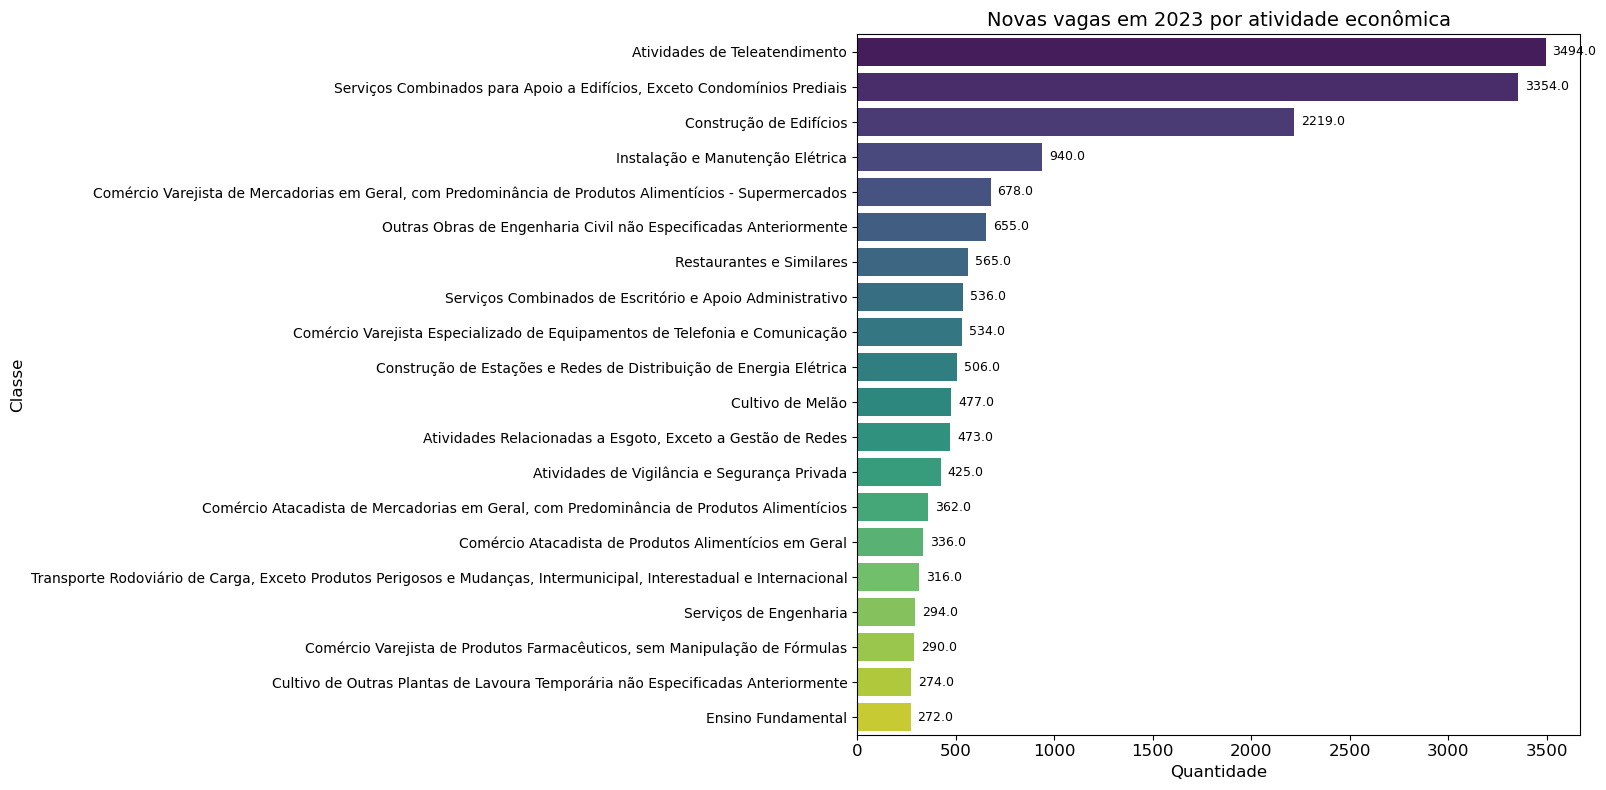

In [100]:
# Criando o gráfico de barras com Seaborn
fig4, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='saldo_movimentacao', y='Desc_subclasse', data=df_subclasse, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Novas vagas em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Saldo de admissões anual por CBO**

In [101]:
df_cbo = df_analise.groupby('Desc_cbo_2002')['saldo_movimentacao'].sum().reset_index().nlargest(20, 'saldo_movimentacao')
total_secao_cbo = df_cbo['saldo_movimentacao'].sum()
df_cbo['%'] = (df_cbo['saldo_movimentacao'] / total_secao) * 100
df_cbo['%'] = df_cbo['%'].round(2)
df_cbo = df_cbo.sort_values(by='saldo_movimentacao', ascending=False).reset_index(drop=True)

df_cbo

,Desc_cbo_2002,saldo_movimentacao,%
0,Operador de Telemarketing Ativo e Receptivo,3519,15.34
1,Servente de Obras,2669,11.64
2,Faxineiro (Desativado em 2010),1944,8.48
3,Assistente Administrativo,1450,6.32
4,Atendente de Lojas e Mercados,1036,4.52
5,"Auxiliar de Escritorio, em Geral",797,3.48
6,Alimentador de Linha de Producao,721,3.14
7,Auxiliar nos Serviços de Alimentação,714,3.11
8,Pedreiro,693,3.02
9,"Recepcionista, em Geral",573,2.5


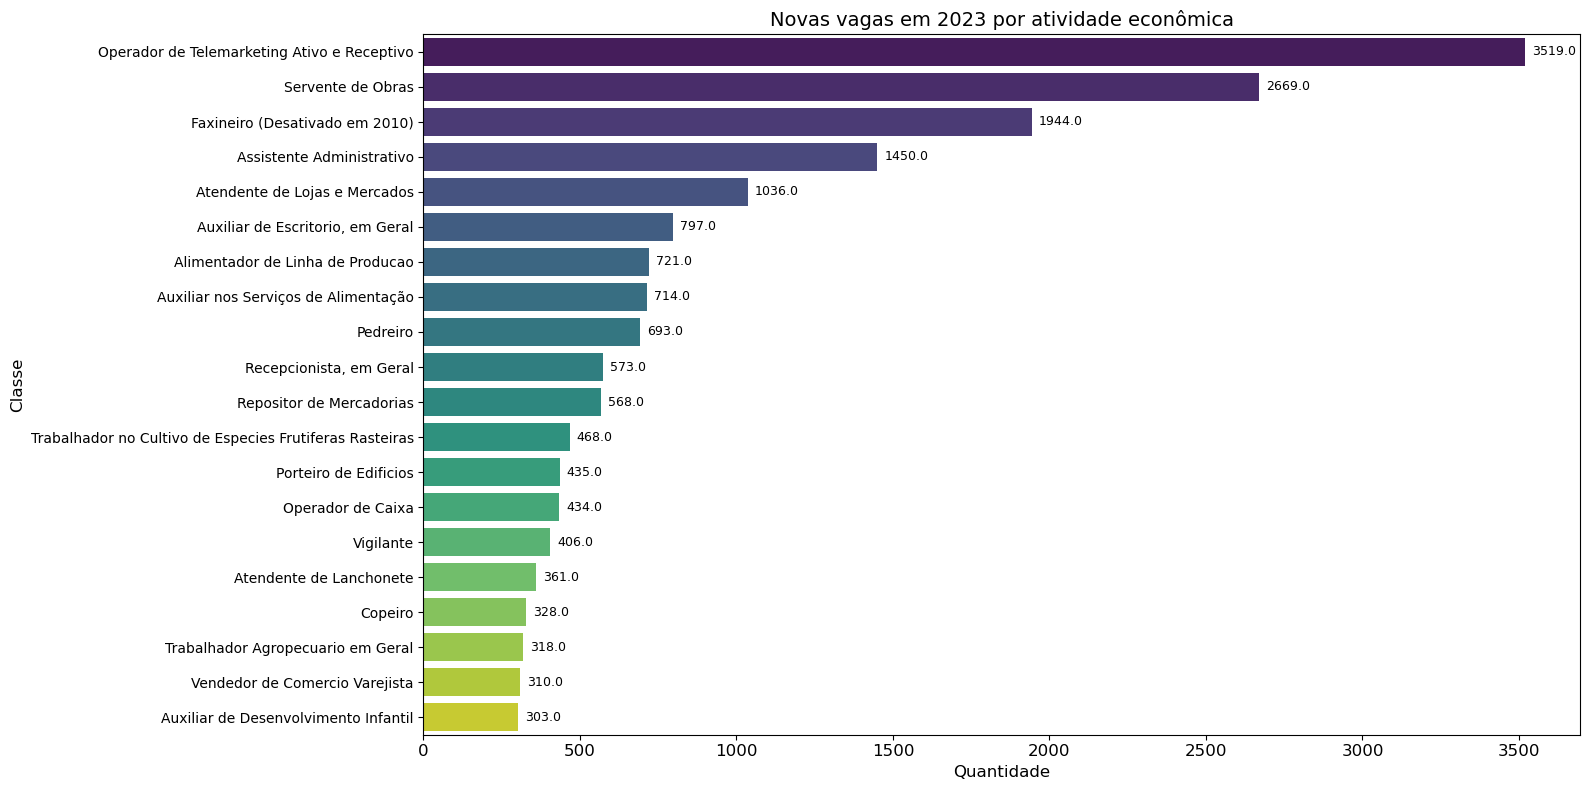

In [103]:
# Criando o gráfico de barras com Seaborn
fig4, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='saldo_movimentacao', y='Desc_cbo_2002', data=df_cbo, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Novas vagas em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()